In [265]:
#import pyforest

In [266]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout




import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [267]:
#Data Collection
# Import Data
# Use Pandas for Data Manupulation
# 'Zero' mean not a fraud Transaction
#'One' Means Fraud transactions
#df = pd.read_csv("UPI payment fraud detection.csv")
df = pd.read_csv("upi_fraud_data.csv")
df.head()


,Transaction_ID,Date,Time,Merchant_ID,Customer_ID,Device_ID,Transaction_Type,Payment_Gateway,Transaction_City,Transaction_State,IP_Address,Transaction_Status,Device_OS,Transaction_Frequency,Merchant_Category,Transaction_Channel,Transaction_Amount_Deviation,Days_Since_Last_Transaction,amount,fraud
0,T00022452,20/04/23,4:50:22 AM,f65a902b-2396-40cc-9593-97e103f1bc15,89aaeceb-21f5-46c8-9de3-89dde6a10a75,c1e0deb4-7c97-4178-a838-38f4a2f0b57c,Refund,SamplePay,Durgapur,Chhattisgarh,140.213.7.48,Completed,MacOS,1,Brand Vouchers and OTT,In-store,25.02,5,396.62,1
1,T00032233,08/08/23,8:09:21 AM,d4a5efcb-4eb6-4d3a-8132-07bb3e6e13a4,8a8962f9-e84a-4573-ab0b-187311978a21,62e14f64-b0ba-4284-889a-51ac05baf33e,Bank Transfer,SamplePay,Rajpur Sonarpur,Himachal Pradesh,184.108.177.45,Pending,Windows,30,Home delivery,Mobile,-36.64,20,121.94,1
2,T00037364,25/06/23,7:49:01 AM,759ad138-9473-4729-8699-3d72c7ffb983,c3f53ce6-e305-4460-a71d-93bde26043ab,4281c542-ac77-4269-b4bb-1de93ac12677,Bank Transfer,Other,New Delhi,Himachal Pradesh,16.106.248.163,Failed,Android,2,Utilities,Online,44.19,22,106.69,1
3,T00015924,28/01/24,5:44:12 AM,d8f561e4-bded-4ef0-bcd8-5494b2e31a94,9f0c5613-7d4c-4454-bee1-c47fbba406a1,058b6488-2469-42f2-bc7f-707921d35cad,Subscription,UPI Pay,Bharatpur,Chhattisgarh,65.245.160.212,Failed,Android,0,Purchases,Online,-54.34,28,3611.11,1
4,T00021805,21/06/23,9:40:59 AM,26fdd7a1-8537-4dfe-bcf7-f5a127b36682,bf9aa6d5-7d3d-43f9-8631-31336720a383,068ff12c-127a-4cfb-9899-ddde37060b28,Investment,Dummy Bank,Sagar,Mizoram,33.172.152.38,Completed,MacOS,1,Other,Online,12.38,25,374.89,1


In [268]:
#Analysing DataSet
#checking Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                647 non-null    object 
 1   Date                          647 non-null    object 
 2   Time                          647 non-null    object 
 3   Merchant_ID                   647 non-null    object 
 4   Customer_ID                   647 non-null    object 
 5   Device_ID                     647 non-null    object 
 6   Transaction_Type              647 non-null    object 
 7   Payment_Gateway               647 non-null    object 
 8   Transaction_City              647 non-null    object 
 9   Transaction_State             647 non-null    object 
 10  IP_Address                    647 non-null    object 
 11  Transaction_Status            647 non-null    object 
 12  Device_OS                     647 non-null    object 
 13  Trans

In [269]:
#df['Time'] = df['Time'].astype(float)

In [270]:
#checking all dataset features (Column)
df.columns

Index(['Transaction_ID', 'Date', 'Time', 'Merchant_ID', 'Customer_ID',
       'Device_ID', 'Transaction_Type', 'Payment_Gateway', 'Transaction_City',
       'Transaction_State', 'IP_Address', 'Transaction_Status', 'Device_OS',
       'Transaction_Frequency', 'Merchant_Category', 'Transaction_Channel',
       'Transaction_Amount_Deviation', 'Days_Since_Last_Transaction', 'amount',
       'fraud'],
      dtype='object')

In [271]:
#descriptive Analysis - It will tell us Numerical features in our dataset

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction_Frequency,647.0,3.564142,6.454543,0.00,1.000,2.00,3.00,50.00
Transaction_Amount_Deviation,647.0,5.014668,56.375914,-99.47,-42.355,8.38,52.29,99.45
Days_Since_Last_Transaction,647.0,15.717156,8.218122,1.00,8.500,16.00,23.00,29.00
amount,647.0,128.839753,364.995747,0.12,17.155,35.00,74.77,4883.62
fraud,647.0,0.239567,0.427150,0.00,0.000,0.00,0.00,1.00


In [272]:
# Data Preparation
# Duplicate Values

df.duplicated().sum()
#df.duplicates()

0

In [273]:
#Missing Values

df.isnull().sum()

#How to deal with missing values if any
# drop is missing values are very less
#Amputation (fill the missing values)
# Forward Fill or Backward Fill
#Linear regression to fill value like mean value but bit recommended due to mean is sensative to outliers (means when data is not follwing normal distribution) , use median value instead





,0
Transaction_ID,0
Date,0
Time,0
Merchant_ID,0
Customer_ID,0
Device_ID,0
Transaction_Type,0
Payment_Gateway,0
Transaction_City,0
Transaction_State,0


In [274]:
#Shape of the data set - total count and features
df.shape

(647, 20)

In [275]:
# Unique value in the dataset
# if whole feature value is unique, then they do not much contributes to data analysis
#will drop those features which are unique
df.nunique()

,0
Transaction_ID,647
Date,302
Time,641
Merchant_ID,647
Customer_ID,647
Device_ID,647
Transaction_Type,7
Payment_Gateway,9
Transaction_City,281
Transaction_State,28


In [276]:
#drop unique values
df.columns

Index(['Transaction_ID', 'Date', 'Time', 'Merchant_ID', 'Customer_ID',
       'Device_ID', 'Transaction_Type', 'Payment_Gateway', 'Transaction_City',
       'Transaction_State', 'IP_Address', 'Transaction_Status', 'Device_OS',
       'Transaction_Frequency', 'Merchant_Category', 'Transaction_Channel',
       'Transaction_Amount_Deviation', 'Days_Since_Last_Transaction', 'amount',
       'fraud'],
      dtype='object')

In [277]:
#droping unique features and updating original df
df.drop(['Transaction_ID','Merchant_ID', 'Customer_ID', 'Device_ID', 'IP_Address', 'Date', 'Time'], axis=1, inplace = True )



In [278]:
df.head()

,Transaction_Type,Payment_Gateway,Transaction_City,Transaction_State,Transaction_Status,Device_OS,Transaction_Frequency,Merchant_Category,Transaction_Channel,Transaction_Amount_Deviation,Days_Since_Last_Transaction,amount,fraud
0,Refund,SamplePay,Durgapur,Chhattisgarh,Completed,MacOS,1,Brand Vouchers and OTT,In-store,25.02,5,396.62,1
1,Bank Transfer,SamplePay,Rajpur Sonarpur,Himachal Pradesh,Pending,Windows,30,Home delivery,Mobile,-36.64,20,121.94,1
2,Bank Transfer,Other,New Delhi,Himachal Pradesh,Failed,Android,2,Utilities,Online,44.19,22,106.69,1
3,Subscription,UPI Pay,Bharatpur,Chhattisgarh,Failed,Android,0,Purchases,Online,-54.34,28,3611.11,1
4,Investment,Dummy Bank,Sagar,Mizoram,Completed,MacOS,1,Other,Online,12.38,25,374.89,1


In [279]:
df.nunique()

,0
Transaction_Type,7
Payment_Gateway,9
Transaction_City,281
Transaction_State,28
Transaction_Status,3
Device_OS,4
Transaction_Frequency,14
Merchant_Category,10
Transaction_Channel,3
Transaction_Amount_Deviation,635


In [280]:
df.groupby('Payment_Gateway')['Payment_Gateway'].agg('count')

,Payment_Gateway
Payment_Gateway,
Alpha Bank,68
Bank of Data,73
CReditPAY,72
Dummy Bank,66
Gamma Bank,74
Other,69
SamplePay,67
Sigma Bank,81
UPI Pay,77


In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_Type              647 non-null    object 
 1   Payment_Gateway               647 non-null    object 
 2   Transaction_City              647 non-null    object 
 3   Transaction_State             647 non-null    object 
 4   Transaction_Status            647 non-null    object 
 5   Device_OS                     647 non-null    object 
 6   Transaction_Frequency         647 non-null    int64  
 7   Merchant_Category             647 non-null    object 
 8   Transaction_Channel           647 non-null    object 
 9   Transaction_Amount_Deviation  647 non-null    float64
 10  Days_Since_Last_Transaction   647 non-null    int64  
 11  amount                        647 non-null    float64
 12  fraud                         647 non-null    int64  
dtypes: fl

In [282]:
df.head(2)

,Transaction_Type,Payment_Gateway,Transaction_City,Transaction_State,Transaction_Status,Device_OS,Transaction_Frequency,Merchant_Category,Transaction_Channel,Transaction_Amount_Deviation,Days_Since_Last_Transaction,amount,fraud
0,Refund,SamplePay,Durgapur,Chhattisgarh,Completed,MacOS,1,Brand Vouchers and OTT,In-store,25.02,5,396.62,1
1,Bank Transfer,SamplePay,Rajpur Sonarpur,Himachal Pradesh,Pending,Windows,30,Home delivery,Mobile,-36.64,20,121.94,1


In [283]:
#Data Cleaning and Feature Engineering (which feature to be used in data analyst)
df.shape

(647, 13)

In [284]:
# Check the target 'fraud'
print('Genuine:', round(df['fraud'].value_counts()[0]/len(df)*100, 2), '% of the transactions')
print('Fraudulent:', round(df['fraud'].value_counts()[1]/len(df)*100, 2), '% of the transactions')

Genuine: 76.04 % of the transactions
Fraudulent: 23.96 % of the transactions


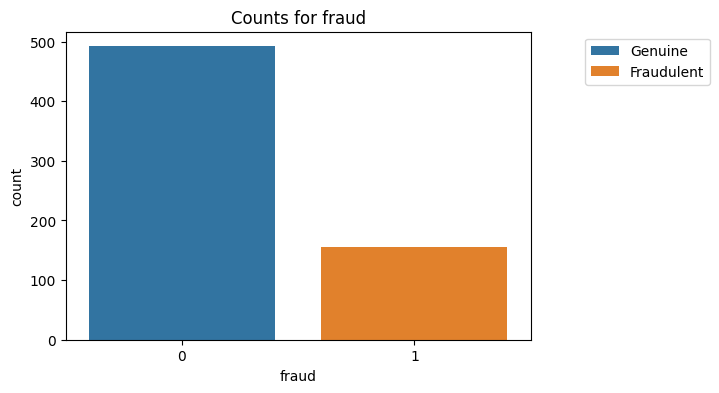

In [285]:
import matplotlib as mpl
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.countplot(x='fraud', data=df, hue='fraud', dodge=False)
plt.title('Counts for fraud')
plt.legend(labels = ['Genuine','Fraudulent'], bbox_to_anchor=(1.4, 1))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

<Axes: >

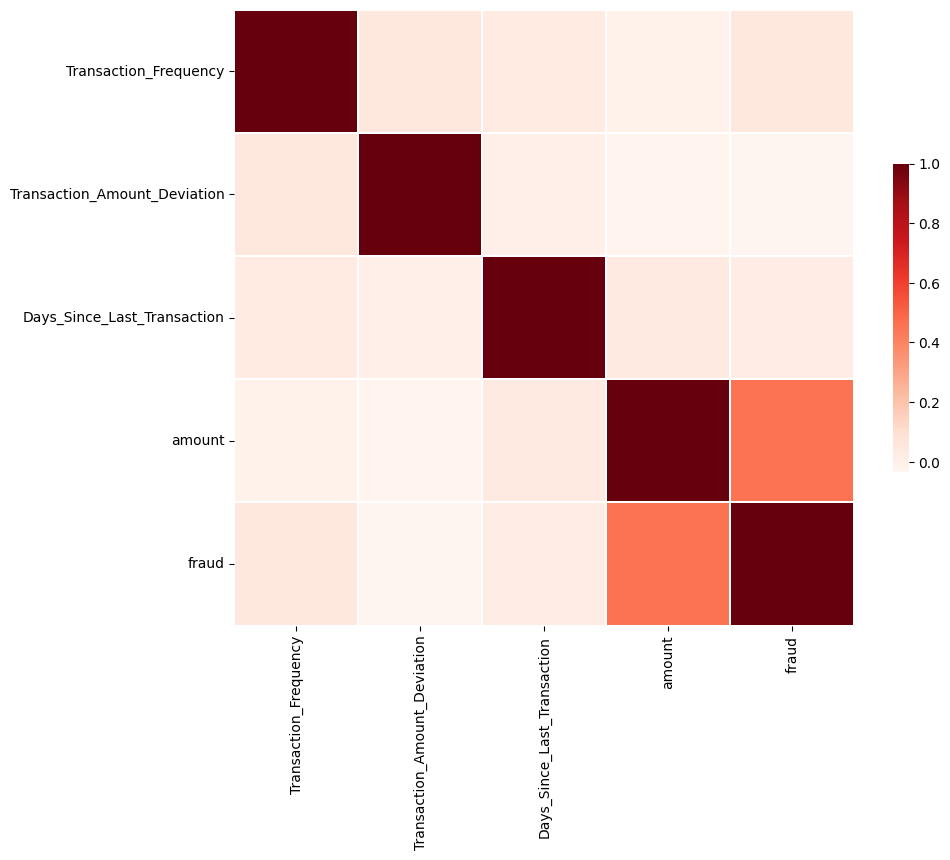

In [286]:
fig = plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(data=corr, cmap='Reds', linewidth=0.1, cbar_kws={"shrink": 0.5})

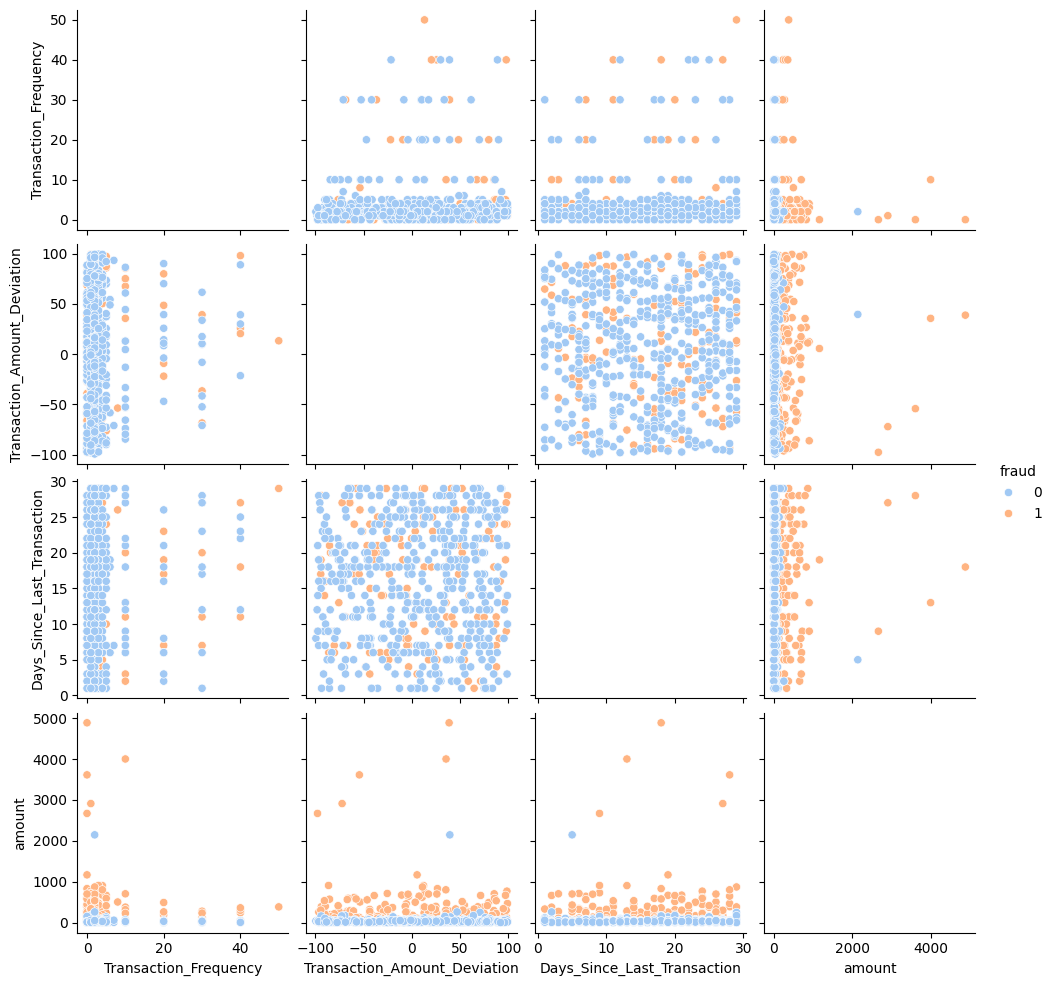

In [287]:
sns.pairplot(data=df, hue='fraud', palette= 'pastel', diag_kind='scatter')

In [288]:
#Fraud Distribution by Fraud Type
import plotly.express as px
fig = px.bar(
    x=df['Transaction_Type'].value_counts().index,
    y=df['Transaction_Type'].value_counts().values,
    title="Fraud by Transaction Type",
    labels={'x': 'Transaction Type', 'y': 'Fraud Count'},
    color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

#Fraud Distribution by Fraud Type - Payment_Gateway
import plotly.express as px
fig = px.bar(
    x=df['Payment_Gateway'].value_counts().index,
    y=df['Payment_Gateway'].value_counts().values,
    title="Fraud by Payment_Gateway",
    labels={'x': 'Payment_Gateway', 'y': 'Fraud Count'},
    color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()
#Fraud Distribution by Fraud Type - Transaction_City
import plotly.express as px
fig = px.bar(
    x=df['Transaction_City'].value_counts().index,
    y=df['Transaction_City'].value_counts().values,
    title="Fraud by Transaction_City",
    labels={'x': 'Transaction_City', 'y': 'Fraud Count'},
    color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()



#Fraud Distribution by Fraud Type - Transaction_Frequency
import plotly.express as px
fig = px.bar(
    x=df['Transaction_Frequency'].value_counts().index,
    y=df['Transaction_Frequency'].value_counts().values,
    title="Fraud by Transaction_Frequency",
    labels={'x': 'Transaction_Frequency', 'y': 'Fraud Count'},
    color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

#Fraud Distribution by Fraud Type - Amount
import plotly.express as px
fig = px.histogram(df, x='amount', nbins=20, title='Fraud by Amount',
                   labels={'amount', 'Fraud Count'},
    color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()


In [289]:
df['Payment_Gateway'] = df['Payment_Gateway'].apply({'Alpha Bank': 1, 'Bank of Data':2, 'CReditPAY':3, 'Dummy Bank':4,  'Gamma Bank':5, 'SamplePay':6, 'Sigma Bank':7, 'UPI Pay':8, 'Other':9 }.get)
df['Transaction_Channel'] = df['Transaction_Channel'].apply({'In-store': 1, 'Mobile':2, 'Online':3}.get)

In [290]:
numeric_c= df.select_dtypes(include=['int64','float64'])
numeric_c.corr()


,Payment_Gateway,Transaction_Frequency,Transaction_Channel,Transaction_Amount_Deviation,Days_Since_Last_Transaction,amount,fraud
Payment_Gateway,1.000000,0.061017,0.047859,0.025995,0.007306,0.001364,0.017751
Transaction_Frequency,0.061017,1.000000,-0.023028,0.045265,0.027643,-0.009595,0.048038
Transaction_Channel,0.047859,-0.023028,1.000000,0.010264,-0.002390,-0.034609,-0.074639
Transaction_Amount_Deviation,0.025995,0.045265,0.010264,1.000000,0.004454,-0.023976,-0.033400
Days_Since_Last_Transaction,0.007306,0.027643,-0.002390,0.004454,1.000000,0.034215,0.022420
amount,0.001364,-0.009595,-0.034609,-0.023976,0.034215,1.000000,0.452355
fraud,0.017751,0.048038,-0.074639,-0.033400,0.022420,0.452355,1.000000


In [291]:
df_data = numeric_c
df_data.head()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Payment_Gateway               647 non-null    int64  
 1   Transaction_Frequency         647 non-null    int64  
 2   Transaction_Channel           647 non-null    int64  
 3   Transaction_Amount_Deviation  647 non-null    float64
 4   Days_Since_Last_Transaction   647 non-null    int64  
 5   amount                        647 non-null    float64
 6   fraud                         647 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 35.5 KB


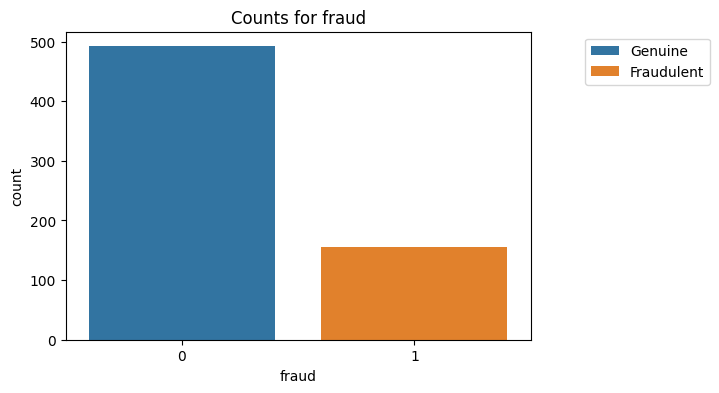

In [292]:
import matplotlib as mpl
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.countplot(x='fraud', data=df_data, hue='fraud', dodge=False)
plt.title('Counts for fraud')
plt.legend(labels = ['Genuine','Fraudulent'], bbox_to_anchor=(1.4, 1))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [293]:
#Train Test Split without under or Over sampling
# Define the predictors and target
X = df_data.drop('fraud', axis=1)
Y = df_data['fraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state = 91)
X.shape, Y.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((647, 6), (647,), (452, 6), (195, 6), (452,), (195,))

In [294]:
model = LogisticRegression()
model.fit(X_train, Y_train)


LogisticRegression()

In [295]:
predictions = model.predict(X_test)

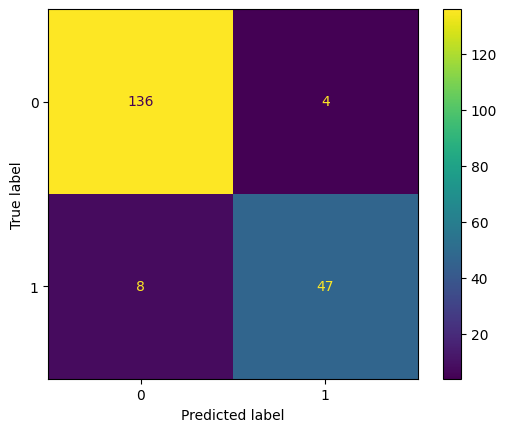

In [296]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
cm = ConfusionMatrixDisplay(confusion_matrix(Y_test, predictions)).plot()

In [297]:
report = classification_report(Y_test, predictions)
print("Classification Report")
print(report)
print('accuracy:%0.4f'%acc,'\tprecision:%0.4f'%prec,'\trecall:%0.4f'%rec,'\tF1-score:%0.4f'%f1)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       140
           1       0.92      0.85      0.89        55

    accuracy                           0.94       195
   macro avg       0.93      0.91      0.92       195
weighted avg       0.94      0.94      0.94       195

accuracy:0.9436 	precision:0.9074 	recall:0.8909 	F1-score:0.8991


In [298]:
#RandomForest

rf = RandomForestClassifier(random_state=42)

In [299]:
# Evaluate the recall score by stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=False)
score = cross_val_score(rf, X_train, Y_train, cv=kf, scoring='recall')

print('Cross Validation Recall Scores: {}'.format(score))
print('Average Cross Validation Recall Score: {}'.format(score.mean()))

Cross Validation Recall Scores: [0.85 0.7  0.75 0.9  0.8 ]
Average Cross Validation Recall Score: 0.8


In [300]:
# Tune hyper-parameters using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [6, 10, 12, 14]
}

rf_grid = GridSearchCV(rf, param_grid, scoring='recall', cv=kf, n_jobs=-1).fit(X_train, Y_train)

print('Best Parameters: {}'.format(rf_grid.best_params_))
print('Best Recall Score: {}'.format(rf_grid.best_score_))

Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Best Recall Score: 0.8099999999999999


In [301]:
# Make predictions on the test set with the best found parameters
rf_pred = rf_grid.predict(X_test)

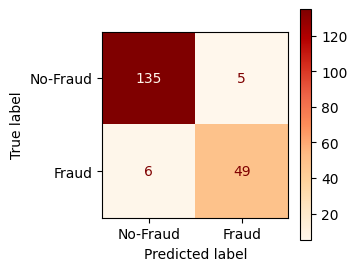

In [302]:
# Visualise the confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(3,3))
display_labels = ['No-Fraud','Fraud']
ConfusionMatrixDisplay.from_predictions(Y_test, rf_pred, display_labels=display_labels, ax=ax, cmap='OrRd')

In [303]:
# Compute the main metrics
rf_recall = recall_score(Y_test, rf_pred)
rf_precision = precision_score(Y_test, rf_pred)
rf_f1 = f1_score(Y_test, rf_pred)
rf_accuracy = accuracy_score(Y_test, rf_pred)

rf_scores = pd.DataFrame(data=[(rf_recall, rf_precision, rf_f1, rf_accuracy)],
                         columns=['Recall','Precision','F1 Score', 'Accuracy'],
                         index=['Random Forest'])

rf_scores.head()

,Recall,Precision,F1 Score,Accuracy
Random Forest,0.890909,0.907407,0.899083,0.94359


In [304]:
rf.fit(X_train,Y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [305]:
Y_pred = rf.predict(X_test)

In [306]:
rf.score(X_test,Y_test)

0.9435897435897436

In [307]:
acc = accuracy_score(Y_test, Y_pred)
prec = precision_score(Y_test, Y_pred)
rec = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
print('accuracy:%0.4f'%acc,'\tprecision:%0.4f'%prec,'\trecall:%0.4f'%rec,'\tF1-score:%0.4f'%f1)

accuracy:0.9436 	precision:0.9074 	recall:0.8909 	F1-score:0.8991


In [308]:
#OverSampling
from imblearn.over_sampling import SMOTE
# Apply SMOTE
smote = SMOTE()
X_resample, y_resample = smote.fit_resample(X, Y.values.ravel())


In [309]:
y_resample

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [310]:
print('Number of total transactions before SMOTE upsampling: ', len(Y), '...after SMOTE upsampling: ', len(y_resample))
print('Number of fraudulent transactions before SMOTE upsampling: ', len(Y[df_data['fraud']==1]),
      '...after SMOTE upsampling: ', np.sum(y_resample[y_resample==1]))
print('non-fraud transactions - 50% = 492')
print('fraud transactions - 50% = 492')

Number of total transactions before SMOTE upsampling:  647 ...after SMOTE upsampling:  984
Number of fraudulent transactions before SMOTE upsampling:  155 ...after SMOTE upsampling:  492
non-fraud transactions - 50% = 492
fraud transactions - 50% = 492


In [311]:
y_resample = pd.DataFrame(y_resample)
X_resample = pd.DataFrame(X_resample)

In [312]:
X_resample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Payment_Gateway               984 non-null    int64  
 1   Transaction_Frequency         984 non-null    int64  
 2   Transaction_Channel           984 non-null    int64  
 3   Transaction_Amount_Deviation  984 non-null    float64
 4   Days_Since_Last_Transaction   984 non-null    int64  
 5   amount                        984 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 46.2 KB


In [313]:
X_train, X_test, y_train, y_test = train_test_split(X_resample,y_resample,test_size=0.3)

In [314]:
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression()

In [315]:
predictions = model.predict(X_resample)

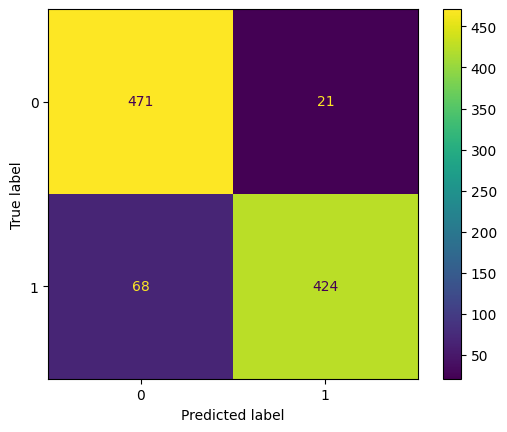

In [316]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_resample, predictions)).plot()

In [317]:
report = classification_report(y_resample, predictions)
print("Classification Report")
print(report)
print('accuracy:%0.4f'%acc,'\tprecision:%0.4f'%prec,'\trecall:%0.4f'%rec,'\tF1-score:%0.4f'%f1)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       492
           1       0.95      0.86      0.91       492

    accuracy                           0.91       984
   macro avg       0.91      0.91      0.91       984
weighted avg       0.91      0.91      0.91       984

accuracy:0.9436 	precision:0.9074 	recall:0.8909 	F1-score:0.8991
